In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
import time
import argparse
from tqdm import tqdm

import pandas as pd
import pickle
import jsonlines
import json

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import numpy as np
import sys
from pathlib import Path
from FiDT5 import FiDT5

import random
from beir_eval import run_direct_rerank_eval
from beir_length_mapping import BEIR_LENGTH_MAPPING

2025-04-18 14:43:57.731193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 14:43:57.731255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 14:43:57.732313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 14:43:58.526565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def read_jsonl(path):
    data = []
    with jsonlines.open(path, 'r') as reader:
        for instance in reader:
            data.append(instance)
    return data

class ListT5Evaluator():
    def __init__(self, args):
        self.idx = 0
        self.imsi = []
        self.args = args
        self.tok = T5Tokenizer.from_pretrained(self.args.model_path)

        # For Evaluate all datasets (Using Folder as input_path)
        if not os.path.isdir(self.args.input_path):
            self.test_file = read_jsonl(self.args.input_path)
            print(f"Input path: {self.args.input_path}")
        self.idx2tokid = self.tok.encode(' '.join([str(x) for x in range(1, self.args.listwise_k+1)]))[:-1]
        self.model = self.load_model()
        self.num_forward = 0

    def write_json_file(self, path, data):
        with open(path, 'w') as f:
            json.dump(data, f, indent=4)
        print(f"Writing to {path} done!")

    def write_jsonl_file(self, path, data):
        if self.args.measure_flops:
            self.prof.stop_profile()
            self.flops = self.prof.get_total_flops()
        else:
            self.flops = 0
        print(f"Flops: {self.flops}!")
        with jsonlines.open(path, 'w') as writer:
            writer.write_all(data)
        print(f"Writing to {path} done!")

    def load_model(self):
        start = time.time()
        print("Loading model..")
        print(f"Loading fid model from {self.args.model_path}")
        print(f"Pooling type: {self.args.pooling_type}")
        model = FiDT5.from_pretrained(self.args.model_path,n_passages = self.args.topk, pooling_type=self.args.pooling_type,
                                       n_special_tokens=self.args.n_special_tokens, tokenizer=self.tok).to('cuda')

        end = time.time()
        print(f"Done! took {end-start} second")
        model.eval()
        if self.args.measure_flops:
            self.prof = FlopsProfiler(model)
            self.prof.start_profile()
        return model

    def make_input_tensors(self, texts):
        raw = self.tok(texts, return_tensors='pt',
                padding=self.args.padding, max_length=self.args.max_input_length,
                truncation=True).to('cuda')
        input_tensors = {'input_ids': raw['input_ids'].unsqueeze(0),
                'attention_mask': raw['attention_mask'].unsqueeze(0)}
        return input_tensors
    
    def make_listwise_text(self, question, ctxs, sep='|'):
        out = []
        if self.args.pooling_type == 'rv':
            for i in range(len(ctxs)):
                if self.args.n_special_tokens > 1:
                    special_str = "".join([f"<Relevance_{x}>" for x in range(1, 1+self.args.n_special_tokens)])
                    text = f"{special_str} | Query: {question} | Context: {ctxs[i]}"                    
                else:
                    text = f"<Relevance> | Query: {question} | Context: {ctxs[i]}"
                out.append(text)
        else:
            for i in range(len(ctxs)):
                if self.args.n_special_tokens > 1:
                    special_str = "".join([f"<extra_id_{x}>" for x in range(0, self.args.n_special_tokens)])
                    text = f"{special_str} | Query: {question} | Context: {ctxs[i]}"
                # text = f"<extra_id_17>, Query: {question}, Context: {ctxs[i]}"
                
                out.append(text)
        return out

    def run_inference(self, input_tensors):
        output = self.model.generate_by_single_logit(**input_tensors,
                                                     max_length = self.args.max_gen_length,
                                                     return_dict=False),
        self.num_forward += 1
        
        return output[0]
 
    def get_rel_index(self, output, mode='default', k=-1):
        if k == -1:
            k = self.args.out_k
        
        gen_out = None
        topk_possible = [str(x) for x in range(1, k+1)]
        
        if mode=='default':
            gen_out = self.tok.batch_decode(output.sequences, skip_special_tokens=True)
            gen_out = gen_out[0].split(' ')
        elif mode=='logit':
            topk_logits = output.scores[0].topk(k + 10).indices
            gen_out = [x.split() for x in self.tok.batch_decode(topk_logits, skip_special_tokens=True)][0]
        
        print("Model output: ", gen_out)        
        out_rel_indexes = []
        for i, x in enumerate(gen_out):
            if x in topk_possible:
                out_rel_indexes.append(x)
                topk_possible.remove(x)
        
        if len(out_rel_indexes) < k:
            if 'rev' in self.args.model_path:
                out_rel_indexes = out_rel_indexes + topk_possible
            else:    
                out_rel_indexes = topk_possible[::-1] + out_rel_indexes

        return out_rel_indexes

    def direct_rerank(self, question, ctxs, k=-1):
        full_input_texts = self.make_listwise_text(question, ctxs)
        try:
            input_tensors = self.make_input_tensors(full_input_texts)
        except:
            import IPython;
            IPython.embed()
            exit()
        output = self.run_inference(input_tensors)

        out_k_rel_index = [str(x+1) for x in output[0]]

        return out_k_rel_index
    
    def run_direct_rerank(self):
        reranked_instances = []
        len_question = []
        for instance in tqdm(self.test_file):

            question = instance[self.args.question_text_key]
            items = instance[self.args.firststage_result_key][:self.args.topk]

            if self.args.initial == 'origin':
                pass
            elif self.args.initial == 'reverse':
                items = items[::-1]
            elif self.args.initial == 'random':
                random.shuffle(items)
            topk_ctxs = [x[self.args.text_key] for x in items]
            self.model.n_passages = len(topk_ctxs)
            # self.model.encoder.encoder_batch_size = self.args.encoder_batch_size
            len_question.append(len(question))

            if len(topk_ctxs) > 0:
                index = self.direct_rerank(question, topk_ctxs, k=self.args.topk)
            else:
                # If no candidate passages are available, skip the instance
                index = []
            reranked_items = []

            for i, pid in enumerate(index):
                pid = int(pid) - 1
                template  = items[pid]
                template['orig_'+self.args.score_key] = template[self.args.score_key]
                template[self.args.score_key] = 100000 - i                

                reranked_items.append(template)
            instance[self.args.firststage_result_key] = reranked_items

            reranked_instances.append(instance)

        self.write_jsonl_file(self.args.output_path, reranked_instances)
        ndcg_k, scores = run_direct_rerank_eval(self.args.output_path, k=self.args.topk)

        if self.args.store_result:
            data_name = self.args.input_path.split('/')[-1].split('.')[0]
            result_file = f"./result_{data_name}.txt"
            log_str = ""
            log_str += f"MODEL : {self.args.model_path}\n"
            log_str += f"n_special_tokens : {self.args.n_special_tokens}\n"
            log_str += f"Token loc : {self.args.special_loc}\n"
            log_str += f"ndcg@10 : {ndcg_k}\n"
            log_str += "==================================================\n"
            with open(result_file, "a", encoding="utf-8") as f:
                f.write(log_str)
        return ndcg_k, scores

In [3]:
def run_reranker(args):
    module = ListT5Evaluator(args)

    he = time.time()
    ndcg_10, scores = module.run_direct_rerank()
    hehe = time.time()
    print(f"Total elapsed time: {hehe-he}")    
    print("Elasped time per query: ", (hehe-he)/len(module.test_file))
    if args.measure_flops:
        flops = module.flops
        num_forward = module.num_forward
    else:
        flops = 0
        num_forward = 0

    return ndcg_10, scores, flops, num_forward

In [4]:
def parse_arg(args=None):
    parser = argparse.ArgumentParser()
    # Dataset key setup
    parser.add_argument('--firststage_result_key', default='bm25_results', type=str)
    parser.add_argument('--docid_key', default='docid', type=str)
    parser.add_argument('--pid_key', default='pid', type=str)
    parser.add_argument('--qrels_key', default='qrels', type=str)
    parser.add_argument('--score_key', default='bm25_score', type=str)
    parser.add_argument('--question_text_key', default='q_text', type=str)
    parser.add_argument('--text_key', default='text', type=str)
    parser.add_argument('--title_key', default='title', type=str)
    parser.add_argument('--pooling_type', default=None, type=str)
    parser.add_argument('--n_special_tokens', default=1, type=int)
    parser.add_argument('--store_result', default=False, type=bool)
    parser.add_argument('--softmax_temp', default=1.0, type=float)
    parser.add_argument('--device', default='cuda:4', type=str) # cuda0, cuda1, cpu
    parser.add_argument('--model_path', default='Soyoung97/ListT5-base', type=str)
    parser.add_argument('--topk', default=100, type=int, help='number of initial candidate passages to consider') 
    parser.add_argument('--score_mode', default='default', type=str, help='default or logit')
    
    parser.add_argument('--max_input_length', type=int, default=-1) # depends on each individual data setup
    parser.add_argument('--padding', default='max_length', type=str)
    parser.add_argument('--listwise_k', default=5, type=int)
    parser.add_argument('--rerank_topk', default=10, type=int)
    parser.add_argument('--decoding_strategy', default='single', type=str)
    parser.add_argument('--target_seq', default='token', type=str)

    parser.add_argument('--encoder-batch-size', default=100, type=int) # Because of the memory issue, we need to Devide the input into small batch size. (max_input_length -> encoder-batch-size. 256 -> 100, 512 -> 50. 1024 -> 25 in 24GB gpu)

    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--input_path', type=str, default='./trec-covid.jsonl')
    parser.add_argument('--output_path', type=str, default='./outputs/trec-covid.jsonl')
    parser.add_argument('--special_loc', default=0, type=int)
    # Testing positional Bias
    parser.add_argument('--initial', default='origin', type=str)

    # profiling setup
    parser.add_argument('--measure_flops', action='store_true')
    parser.add_argument('--skip_no_candidate', action='store_true', help='skip instances with no gold qrels included at first-stage retrieval for faster inference, only works when gold qrels are available')
    parser.add_argument('--skip_issubset', action='store_true', help='skip the rest of reranking when the gold qrels is a subset of reranked output for faster inference, only works when gold qrels are available')
    
    return parser.parse_args(args)

In [5]:
arguments = ['--input_path', './eval_data/baseline/dl20.jsonl',
             '--output_path', './outputs/listt5-dl20_default.jsonl',
             '--topk', '100',
             '--pooling_type', 'extra',
             '--n_special_tokens', '4',
             '--model_path', '/home/tako/kjun/checkpoints/temp/0.5_0.0/tfmr_7_step2496']
args = parse_arg(arguments)
args.max_gen_length = args.topk + 1
print(args)

Namespace(firststage_result_key='bm25_results', docid_key='docid', pid_key='pid', qrels_key='qrels', score_key='bm25_score', question_text_key='q_text', text_key='text', title_key='title', pooling_type='extra', n_special_tokens=4, store_result=False, softmax_temp=1.0, device='cuda:4', model_path='/home/tako/kjun/checkpoints/temp/0.5_0.0/tfmr_7_step2496', topk=100, score_mode='default', max_input_length=-1, padding='max_length', listwise_k=5, rerank_topk=10, decoding_strategy='single', target_seq='token', encoder_batch_size=100, seed=0, input_path='./eval_data/baseline/dl20.jsonl', output_path='./outputs/listt5-dl20_default.jsonl', special_loc=0, initial='origin', measure_flops=False, skip_no_candidate=False, skip_issubset=False, max_gen_length=101)


In [6]:
# model_path = ['/home/tako/kjun/checkpoints/temp/t/tfmr_9_step3120', '/home/tako/kjun/checkpoints/temp/0.5/tfmr_9_step3120', '/home/tako/kjun/checkpoints/temp/tfmr_0_step30000', '/home/tako/kjun/checkpoints/temp/tfmr_0_step25000']
# model_path = ['/home/tako/kjun/checkpoints/temp/0.0_0.5']
# model_path = ['/home/tako/kjun/checkpoints/listt5/test/ortho_weight/10','/home/tako/kjun/checkpoints/listt5/test/ortho_weight/100','/home/tako/kjun/checkpoints/listt5/test/ortho_weight/1000','/home/tako/kjun/checkpoints/listt5/test/ortho_weight/10000']

model_path = ['/data/kjun/checkpoints/MVT5_v2_first/MVT5_s_11_special_4_seed_0_first_0_base_extra/tfmr_7_step2496']

In [7]:
ranking_score_all = []
lhs_all = []
psg_emb_all = []

for path in model_path:
    args.model_path = path
    module = ListT5Evaluator(args)
    for name in BEIR_LENGTH_MAPPING:
        if name in module.args.input_path:
            module.args.max_input_length = BEIR_LENGTH_MAPPING[name]

    torch.cuda.empty_cache()    

    ranking_score = []
    lhs = []
    psg_emb = []
    for instance in tqdm(module.test_file):
        question = instance[module.args.question_text_key]
        items = instance[module.args.firststage_result_key][:module.args.topk]
        topk_ctxs = [x[module.args.text_key] for x in items]
        qrels = instance[module.args.qrels_key]
        
        module.model.n_passages = len(topk_ctxs)
        module.model.encoder.encoder_batch_size = module.args.encoder_batch_size
        # len_question.append(len(question))
        
        full_input_texts = module.make_listwise_text(question, topk_ctxs)
        input_tensors = module.make_input_tensors(full_input_texts)
        outputs = module.model.forward(input_ids=input_tensors['input_ids'], attention_mask=input_tensors['attention_mask'],)
        ranking_score.append(outputs.ranking.cpu())
        lhs.append(outputs.last_hidden_state.cpu())
        psg_emb.append(outputs.passage_embed.cpu())
    
    ranking_score_all.append(torch.stack(ranking_score, dim=0))
    lhs_all.append(torch.stack(lhs, dim=0))
    psg_emb_all.append(torch.stack(psg_emb, dim=0))
    

Input path: ./eval_data/baseline/dl20.jsonl
Loading model..
Loading fid model from /data/kjun/checkpoints/MVT5_v2_first/MVT5_s_11_special_4_seed_0_first_0_base_extra/tfmr_7_step2496
Pooling type: extra
Done! took 2.714604139328003 second


100%|██████████| 54/54 [00:19<00:00,  2.72it/s]


In [ ]:
lhs_all_tensor = torch.stack(lhs_all, dim=0) # 1, 54, 4, 1, 768
psg_emb_all_tensor = torch.stack(psg_emb_all, dim=0) # 4, 54, 4, 100, 768

In [29]:
lhs_norm_test = F.normalize(lhs_all_tensor, p=2, dim=1)

lhs_norm.norm(dim=-1)


tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [15]:
lhs_all_tensor[0][0][0].norm()

tensor(1.1985)

In [16]:
# (4, 54, 4, 768) # lhs
# (4, 54, 4, 100, 768) # psg_emb
import torch.nn.functional as F

# Calculate Cosine Similiarity between lhs (4)
lhs_cos_all = []
for i in range(lhs_all_tensor.size(0)):
    lhs_temp = lhs_all_tensor[i] # 54, 4, 1, 768
    lhs_cos = []
    for q in range(lhs_temp.size(0)):
        lhs = lhs_temp[q].view(4, 768) # 4 768

        lhs_norm = F.normalize(lhs, p=2, dim=1)
        lhs_cos_temp = torch.matmul(lhs_norm, lhs_norm.T) # 4 4
        lhs_cos.append(lhs_cos_temp)

    lhs_cos = torch.stack(lhs_cos, dim=0) # 54, 4, 4
    lhs_cos_all.append(lhs_cos)

lhs_cos_all_tensor = torch.stack(lhs_cos_all, dim=0) # 4, 54, 4, 4

    # psg_emb = psg_emb_all_tensor[i].reshape(-1, 100, 768)
    
    # lhs = lhs.reshape(-1, 4, 768)
    # psg_emb = psg_emb.reshape(-1, 100, 768)
    
    # cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
    # sim = cos(lhs.unsqueeze(2), psg_emb.unsqueeze(1))
    # print(sim.size())


In [17]:
import torch.nn.functional as F

# Calculate Cosine Similiarity between psg (4)
psg_cos_all = []
for i in range(psg_emb_all_tensor.size(0)):
    psg_temp = psg_emb_all_tensor[i] # 54, 4, 100, 768
    psg_cos = []
    for q in range(psg_temp.size(0)):
        psg_cos_2 = []
        for p in range(psg_temp.size(2)):
            psg = psg_temp[q, :, p, :].view(4, -1)
            psg_norm = F.normalize(psg, p=2, dim=1)
            psg_cos_temp = torch.matmul(psg_norm, psg_norm.T) # 4 4
            psg_cos_2.append(psg_cos_temp)
        psg_cos_2 = torch.stack(psg_cos_2, dim=0)
        psg_cos.append(psg_cos_2)
    psg_cos = torch.stack(psg_cos, dim=0) # 54, 4, 4
    psg_cos_all.append(psg_cos)

psg_cos_all_tensor = torch.stack(psg_cos_all, dim=0) # 4, 54, 4, 4

In [18]:
import torch

# 대각선 마스킹
eye = torch.eye(4, device=lhs_cos_all_tensor.device).bool()  # [4, 4]
mask = ~eye  # 대각선 False, 나머지 True

# 마스크를 (1, 1, 4, 4)로 브로드캐스팅
masked_tensor = lhs_cos_all_tensor.masked_select(mask.unsqueeze(0).unsqueeze(0))  # shape: (4*54*12,)

# reshape해서 [4, 54, 12]
masked_tensor = masked_tensor.view(lhs_cos_all_tensor.size(0), 54, -1)

# 평균 내기 → [4, 54, 1]
mean_sim = masked_tensor.mean(dim=2, keepdim=True)

print(mean_sim.shape)  # torch.Size([4, 54, 1])

torch.Size([1, 54, 1])


In [19]:
mean_sim.mean(dim=1)

tensor([[0.9620]])

In [20]:
import torch
# 1. 대각선 마스크 만들기
eye = torch.eye(4, device=psg_cos_all_tensor.device).bool()         # shape: [4, 4]
mask = ~eye                                                         # shape: [4, 4], diagonal 제외

# 2. mask broadcast: (1, 1, 1, 4, 4)
mask = mask.view(1, 1, 1, 4, 4)

# 3. masked_select로 대각선 제외 값만 추출
masked_values = psg_cos_all_tensor.masked_select(mask)  # shape: (4 * 54 * 100 * 12,)

# 4. reshape → [4, 54, 100, 12]
masked_values = masked_values.view(lhs_cos_all_tensor.size(0), 54, 100, -1)

# 5. 평균 → [4, 54, 100, 1]
mean_sim = masked_values.mean(dim=3, keepdim=True)

print(mean_sim.shape)  # torch.Size([4, 54, 100, 1])

torch.Size([1, 54, 100, 1])


In [21]:
mean_sim_psg = mean_sim.mean(dim=2)

In [22]:
mean_sim_psg.mean(dim=1)

tensor([[0.9032]])

### Orthogonal 10

In [23]:
ranking_score_all_tensor = torch.stack(ranking_score_all, dim=0) # 4, 54, 4
ranking_score_all_tensor.shape

torch.Size([1, 54, 1, 4, 100])

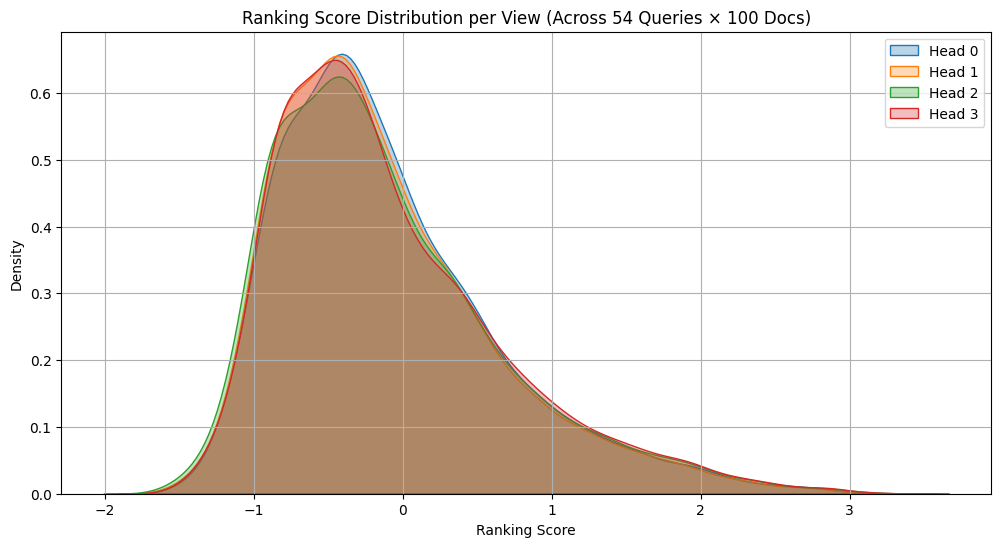

In [27]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
# ranking_score_tensor = torch.stack(ranking_score, dim=0)
# 텐서 차원 축소: [54, 4, 1, 100] → [54, 4, 100]
tensor0 = ranking_score_all_tensor[0].squeeze(1)

# reshape: [54, 4, 100] → [4, 54*100]
# 즉, 각 head 별로 5400개의 score를 flatten
flattened_scores0 = tensor0.permute(1, 0, 2).reshape(4, -1)

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    sns.kdeplot(flattened_scores0[i].cpu().numpy(), label=f'Head {i}', fill=True, alpha=0.3)

plt.xlabel('Ranking Score')
plt.ylabel('Density')
plt.title('Ranking Score Distribution per View (Across 54 Queries × 100 Docs)')
plt.legend()
plt.grid(True)
plt.show()


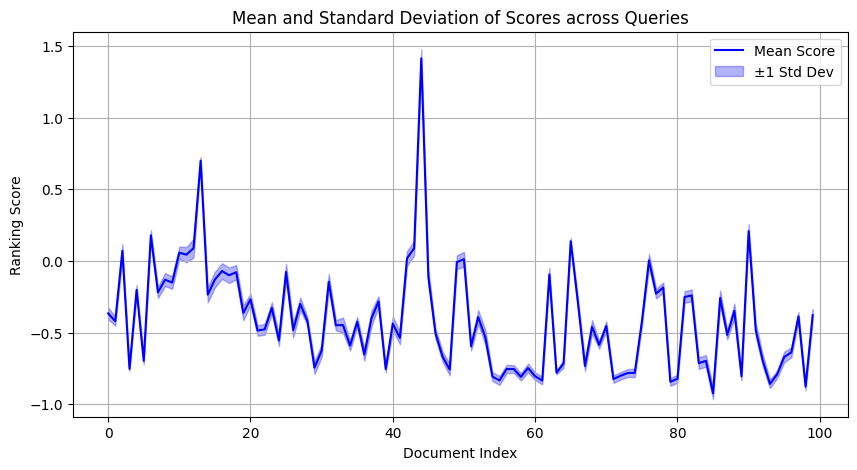

In [28]:
import matplotlib.pyplot as plt
import torch

# 예: 각각 [100] shape의 텐서라고 가정
means = flattened_scores0[:,:100].mean(axis=0)
stds = flattened_scores0[:,:100].std(axis=0)

x = list(range(len(means)))  # 문서 인덱스 (0~99)

plt.figure(figsize=(10, 5))
plt.plot(x, means, label='Mean Score', color='blue')
plt.fill_between(x, means - stds, means + stds, color='blue', alpha=0.3, label='±1 Std Dev')

plt.xlabel('Document Index')
plt.ylabel('Ranking Score')
plt.title('Mean and Standard Deviation of Scores across Queries')
plt.grid(True)
plt.legend()
plt.show()


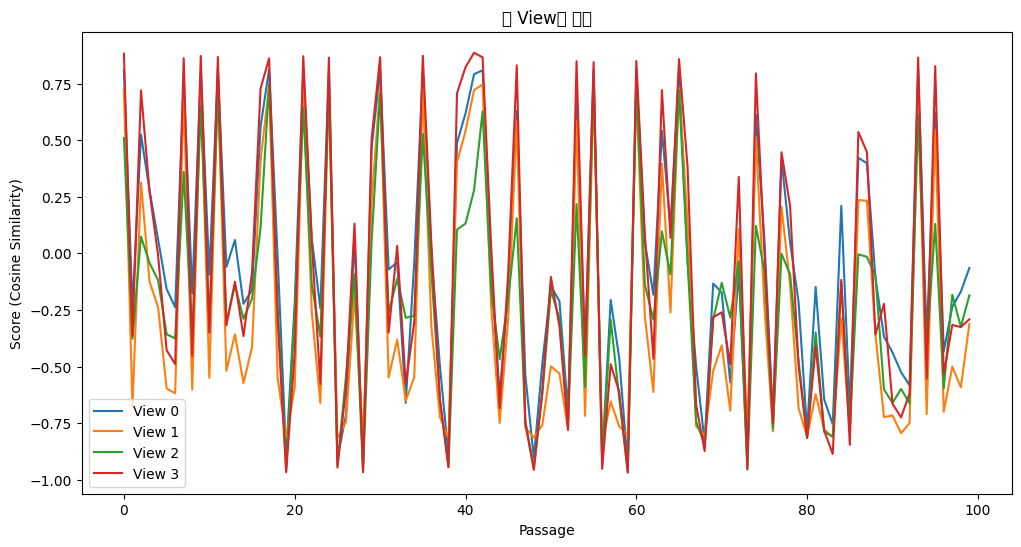

In [38]:
import torch
import matplotlib.pyplot as plt

# 예를 들어 flattened_scores0 텐서의 크기가 [4, 5400]라고 가정합니다.
# 만약 GPU에 있다면 CPU로 옮기고 NumPy 배열로 변환합니다.
scores_np = flattened_scores0.cpu().numpy()  # GPU 텐서인 경우
scores_np = scores_np[:, 200:300]

# 플롯 생성
plt.figure(figsize=(12, 6))

# 4개의 View에 대해 각각의 그래프를 그리기
for i in range(4):
    plt.plot(scores_np[i], label=f"View {i}")

# 제목, x축, y축 레이블 및 범례 추가
plt.title("각 View의 점수")
plt.xlabel("Passage")
plt.ylabel("Score (Cosine Similarity)")
plt.legend()

# 그래프 표시
plt.show()


In [ ]:
stds

tensor([0.0336, 0.0237, 0.0253, 0.0675, 0.0189, 0.0519, 0.1046, 0.0188, 0.0153,
        0.0254, 0.0298, 0.0382, 0.0421, 0.0780, 0.0485, 0.0390, 0.0326, 0.0391,
        0.0316, 0.0297, 0.0150, 0.0565, 0.0268, 0.0181, 0.0328, 0.0439, 0.0264,
        0.0321, 0.0192, 0.0529, 0.0428, 0.0286, 0.0560, 0.0335, 0.0109, 0.0559,
        0.0550, 0.0327, 0.0313, 0.0509, 0.0230, 0.0401, 0.0372, 0.0276, 0.1617,
        0.0471, 0.0280, 0.0434, 0.0843, 0.0355])

### Orthogonal 0.0

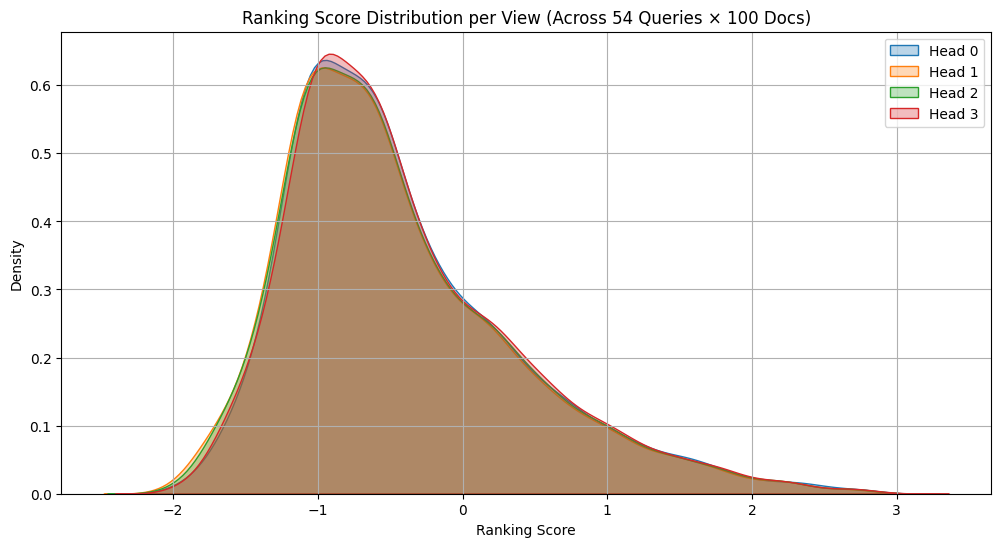

In [ ]:
ranking_score_tensor4 = torch.stack(ranking_score4, dim=0)
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서 차원 축소: [54, 4, 1, 100] → [54, 4, 100]
tensor4 = ranking_score_tensor4.squeeze(2)

# reshape: [54, 4, 100] → [4, 54*100]
# 즉, 각 head 별로 5400개의 score를 flatten
flattened_scores4 = tensor4.permute(1, 0, 2).reshape(4, -1)

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    sns.kdeplot(flattened_scores4[i].cpu().numpy(), label=f'Head {i}', fill=True, alpha=0.3)

plt.xlabel('Ranking Score')
plt.ylabel('Density')
plt.title('Ranking Score Distribution per View (Across 54 Queries × 100 Docs)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
flattened_scores.mean(axis=0), flattened_scores4.mean(axis=0)

(tensor([-0.5477, -0.6887, -0.0680,  ..., -1.2623, -0.9482, -1.3259]),
 tensor([-0.5701, -0.6003, -0.0588,  ..., -1.1880, -1.0282, -1.2127]))

In [ ]:
flattened_scores.std(axis=0), flattened_scores4.std(axis=0)

(tensor([0.0503, 0.0436, 0.0300,  ..., 0.1481, 0.1042, 0.1519]),
 tensor([0.0155, 0.0088, 0.0209,  ..., 0.0288, 0.0351, 0.0278]))

### Orthogonal 0.5 FIRST

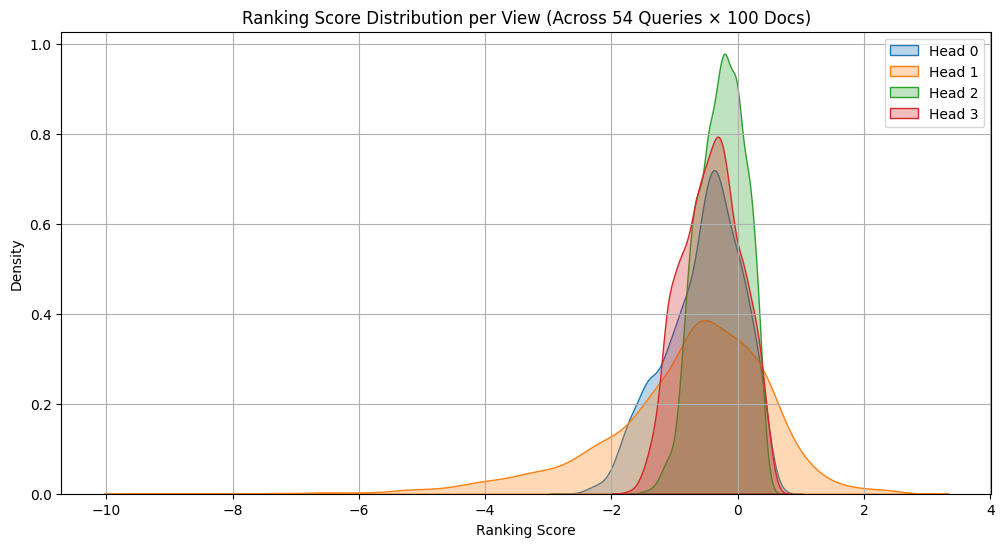

In [ ]:
ranking_score_tensor3 = torch.stack(ranking_score3, dim=0)
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서 차원 축소: [54, 4, 1, 100] → [54, 4, 100]
tensor3 = ranking_score_tensor3.squeeze(2)

# reshape: [54, 4, 100] → [4, 54*100]
# 즉, 각 head 별로 5400개의 score를 flatten
flattened_scores3 = tensor3.permute(1, 0, 2).reshape(4, -1)

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    sns.kdeplot(flattened_scores3[i].cpu().numpy(), label=f'Head {i}', fill=True, alpha=0.3)

plt.xlabel('Ranking Score')
plt.ylabel('Density')
plt.title('Ranking Score Distribution per View (Across 54 Queries × 100 Docs)')
plt.legend()
plt.grid(True)
plt.show()


### Orthogonal 0.0 FIRST

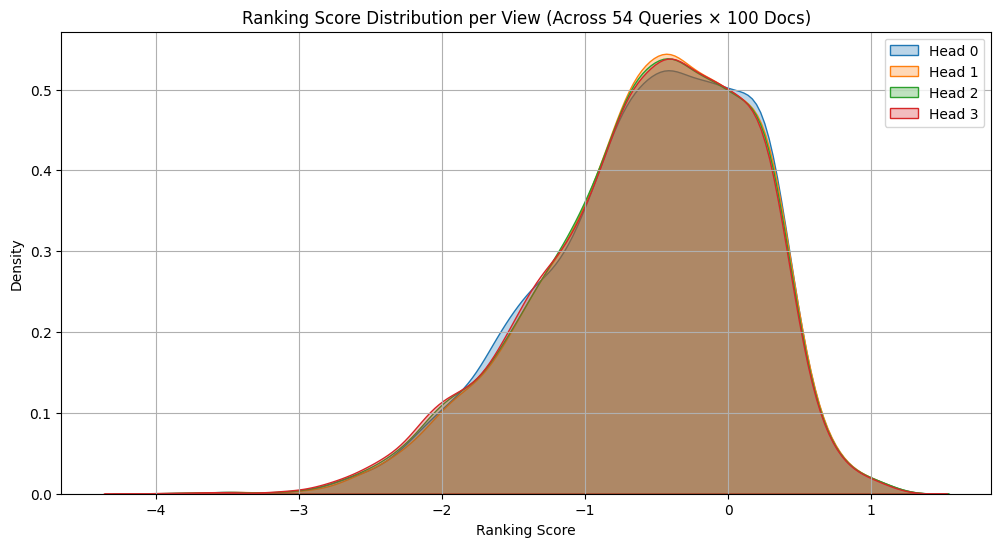

In [ ]:
ranking_score_tensor2 = torch.stack(ranking_score2, dim=0)
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서 차원 축소: [54, 4, 1, 100] → [54, 4, 100]
tensor2 = ranking_score_tensor2.squeeze(2)

# reshape: [54, 4, 100] → [4, 54*100]
# 즉, 각 head 별로 5400개의 score를 flatten
flattened_scores2 = tensor2.permute(1, 0, 2).reshape(4, -1)

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    sns.kdeplot(flattened_scores2[i].cpu().numpy(), label=f'Head {i}', fill=True, alpha=0.3)

plt.xlabel('Ranking Score')
plt.ylabel('Density')
plt.title('Ranking Score Distribution per View (Across 54 Queries × 100 Docs)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
flattened_scores.shape

torch.Size([4, 5400])

### Flattened Scores : 0.5 Second
### Flattened Scores 2 : 0.0 FIRST
### Flattened Scores 3 : 0.5 FIRST
### Flattened Scores 4 : 0.0 Second

In [ ]:
flattened_scores.mean(axis=0), flattened_scores4.mean(axis=0), flattened_scores3.mean(axis=0), flattened_scores2.mean(axis=0)

(tensor([-0.5477, -0.6887, -0.0680,  ..., -1.2623, -0.9482, -1.3259]),
 tensor([-0.5701, -0.6003, -0.0588,  ..., -1.1880, -1.0282, -1.2127]),
 tensor([-0.6988, -0.4334, -0.1413,  ..., -0.8525, -0.2978, -0.7573]),
 tensor([-0.6173, -0.3435, -0.0165,  ..., -0.6004, -0.1598, -0.4750]))

In [ ]:
flattened_scores.std(axis=0), flattened_scores4.std(axis=0), flattened_scores3.std(axis=0), flattened_scores2.std(axis=0)

(tensor([0.0503, 0.0436, 0.0300,  ..., 0.1481, 0.1042, 0.1519]),
 tensor([0.0155, 0.0088, 0.0209,  ..., 0.0288, 0.0351, 0.0278]),
 tensor([0.1905, 0.1341, 0.1972,  ..., 0.6141, 0.6260, 0.6081]),
 tensor([0.0080, 0.0063, 0.0090,  ..., 0.0155, 0.0161, 0.0234]))

In [ ]:
flattened_scores4.std(axis=0)

tensor([0.0155, 0.0088, 0.0209,  ..., 0.0288, 0.0351, 0.0278])

In [ ]:
flattened_scores4.mean(axis=0)

tensor([-0.5701, -0.6003, -0.0588,  ..., -1.1880, -1.0282, -1.2127])

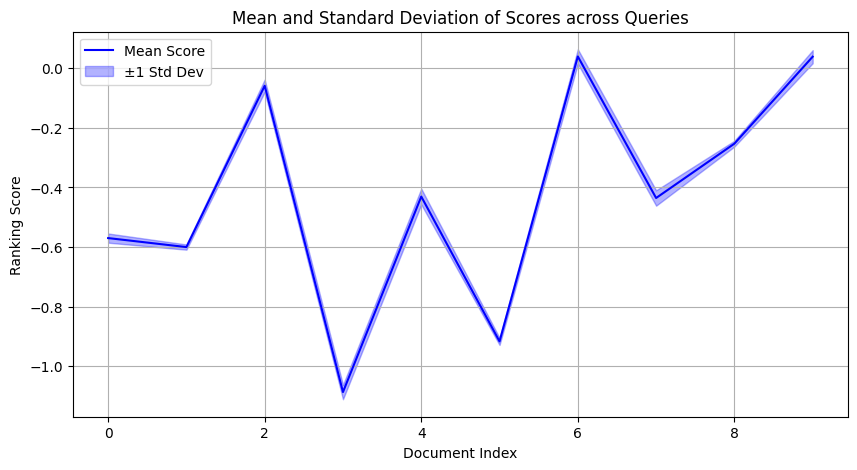

In [ ]:
import matplotlib.pyplot as plt
import torch

# 예: 각각 [100] shape의 텐서라고 가정
means = flattened_scores4[:,:10].mean(axis=0)
stds = flattened_scores4[:,:10].std(axis=0)

x = list(range(len(means)))  # 문서 인덱스 (0~99)

plt.figure(figsize=(10, 5))
plt.plot(x, means, label='Mean Score', color='blue')
plt.fill_between(x, means - stds, means + stds, color='blue', alpha=0.3, label='±1 Std Dev')

plt.xlabel('Document Index')
plt.ylabel('Ranking Score')
plt.title('Mean and Standard Deviation of Scores across Queries')
plt.grid(True)
plt.legend()
plt.show()


In [39]:
import matplotlib.pyplot as plt
import torch

# 예: 각각 [100] shape의 텐서라고 가정
means = flattened_scores[:,:100].mean(axis=0)
stds = flattened_scores[:,:100].std(axis=0)

x = list(range(len(means)))  # 문서 인덱스 (0~99)

plt.figure(figsize=(10, 5))
plt.plot(x, means, label='Mean Score', color='blue')
plt.fill_between(x, means - stds, means + stds, color='blue', alpha=0.3, label='±1 Std Dev')

plt.xlabel('Document Index')
plt.ylabel('Ranking Score')
plt.title('Mean and Standard Deviation of Scores2 across Queries')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'flattened_scores' is not defined